# Analyse results

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../')
sys.path.append('../notebooks/')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
matplotlib.style.use('../notebooks/styles.mplstyle')

from src.dataset import Dataset
from src.representations import REPRESENTATIONS

# from scipy.spatial.distance import squareform
# from unidip.dip import diptst as diptest
from tableone.modality import hartigan_diptest

In [2]:
def format_p_value(p_value, threshold=.01, simple=True, equation=True):
    if threshold < p_value:
        return f'p = {p_value:.2f}' if equation else f'{p_value:.3f}'
    elif p_value < 1e-10 and equation:
        return 'p ≈ 0'
    elif p_value < threshold and simple:
        return f'p < {threshold}'
    else:
        s = f'{p_value:.1e}'.replace('e-0', 'e-')
        return f'p = {s}' if equation else f'{s}'

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def p_value_stars(p_value):
    if p_value < 0.0001:
        return '***'
    elif p_value < 0.001:
        return '**'
    elif p_value < 0.01:
        return '*'
    else:
        return 'n.s.'

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


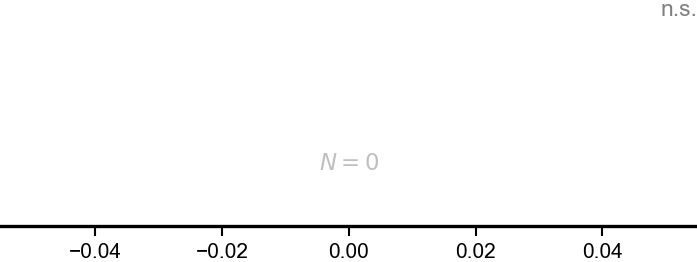

In [40]:
def show_similarity_distribution(dataset, representation, metric, 
                                 kde_rescale=0.8, min_contours=50, 
                                 ax=None, bar_kwargs={}, plt_kwargs={}, **subset_kwargs):
    if ax is None: ax = plt.gca()
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
    try:
        hist, bins = dataset.similarity_hist(representation, metric, **subset_kwargs)
        xs, ys = dataset.similarity_kde(representation, metric, **subset_kwargs).T
        p_value = hartigan_diptest(dataset.similarities(representation, metric, **subset_kwargs))
    except:
        return
    
    num_contours = dataset.subset_size(**subset_kwargs)
    
    alpha = 0.5 if p_value < 0.01 else 0.25
    alpha = alpha if num_contours > min_contours else .15
    bar_kwds = dict(alpha=alpha)
    bar_kwds.update(bar_kwargs)
    ax.bar(bins[:-1], hist, bins[1:]-bins[:-1], **bar_kwds)
    
    if num_contours >= min_contours:
        ls = '-' if p_value < 0.01 else (0, (5, 1))
        plt_kwds = dict(ls=ls)
        plt_kwds.update(plt_kwargs)
        if len(xs) > 0:
            ax.plot(xs, ys * kde_rescale * max(hist) / max(ys), **plt_kwds)
    else:
        ax.annotate(f'$N={num_contours}$', xy=(.5, .25), xycoords='axes fraction', 
                    ha='center', alpha=.25, fontsize=5.5)
    
    ax.annotate(f'{p_value_stars(p_value)}', 
                xy=(1, 1), xycoords='axes fraction',
                xytext=(0, 0), textcoords='offset points',
                ha='right', va='top', fontsize=5.5, color='0.5')
    
    
dataset = Dataset('creighton-phrase')
plt.figure(figsize=(3, 1))
show_similarity_distribution(dataset, 'pitch', 'eucl', 
                             limit=2000, length=3,
                             bar_kwargs=dict(color='C1'), plt_kwargs=dict(color='C1'))

In [31]:
def get_groups(subset_size=1000, limit_eucl=2000, limit_dtw=500):
    return [
        {
            'title': 'Pitch representations with Euclidean distance',
            'color': 'C0',
            'metric': 'eucl',
            'subset': dict(subset_size=subset_size, limit=limit_eucl),
            'label_column': 0,
            'items': [
                ('pitch', 0, 0),
                ('pitch_centered', 0, 1),
                ('pitch_normalized', 0, 2),
                ('pitch_tonicized', 0, 3),
                ('pitch_finalized', 0, 4),
            ]
        },

        {
            'title': 'Pitch representations with DTW distance',
            'color': 'C1',
            'metric': 'dtw',
            'subset': dict(subset_size=subset_size, limit=limit_dtw),
            'label_column': 0,
            'items': [
                ('pitch', 1, 0),
                ('pitch_centered',  1, 1),
                ('pitch_normalized', 1, 2),
                ('pitch_tonicized', 1, 3),
                ('pitch_finalized', 1, 4),
            ]

        },

        {
            'title': 'Cosine representations with Euclidean distance',
            'color': 'C2',
            'metric': 'eucl',
            'subset': dict(subset_size=subset_size, limit=limit_eucl),
            'label_column': 0,
            'items': [
                ('cosine', 2, 0),
                ('cosine_centered', 2, 1),
                ('cosine_normalized', 2, 2),
                ('cosine_tonicized', 2, 3),
                ('cosine_finalized', 2, 4),
            ]
        },

        {
            'title': 'Relative repr. with Euclidean distance',
            'color': 'C3',
            'metric': 'eucl',
            'subset': dict(subset_size=subset_size, limit=limit_eucl),
            'label_column': 0,
            'items': [
                ('interval', 3, 0),
                ('smooth_derivative', 3, 1)
            ]   
        },

        {
            'title': 'Relative repr. with DTW distance',
            'color': 'C4',
            'metric': 'dtw',
            'subset': dict(subset_size=subset_size, limit=limit_dtw),
            'label_column': 3,
            'items': [
                ('interval', 3, 3),
                ('smooth_derivative', 3, 4)
            ]   
        }
    ]

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
def group_title(label, ax=None, **kwargs):
    if ax is None: ax = plt.gca()
    kwds = dict(xy=(0, 1), xycoords='axes fraction',
                xytext=(0, 12), textcoords='offset points',
                va='baseline', ha='left', 
                fontweight='bold', fontsize=6.5)
    kwds.update(kwargs)
    ax.annotate(label, **kwds)
    
def row_label(label,  ax=None, **kwargs):
    if ax is None: ax = plt.gca()
    kwds = dict(xy=(0,0), xycoords='axes fraction',
                xytext=(-5, 0), textcoords='offset points',
                va='baseline', ha='right', 
                fontsize=5.5, color='0.4')
    kwds.update(kwargs)
    ax.annotate(label, **kwds)

def col_label(label,  ax=None, **kwargs):
    if ax is None: ax = plt.gca()
    kwds = dict(xy=(0,1), xycoords='axes fraction',
                xytext=(0, 3), textcoords='offset points',
                va='baseline', ha='left', 
                fontsize=5.5, color='0.4')
    kwds.update(kwargs)
    ax.annotate(label, **kwds)

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
../src/representations_h5.py:49: RuntimeWarning: invalid value encountered in true_divide
  normalized = (contours - minima) / (maxima - minima)
../src/representations_h5.py:49: RuntimeWarning: invalid value encountered in true_divide
  normalized = (contours - minima) / (maxima - minima)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


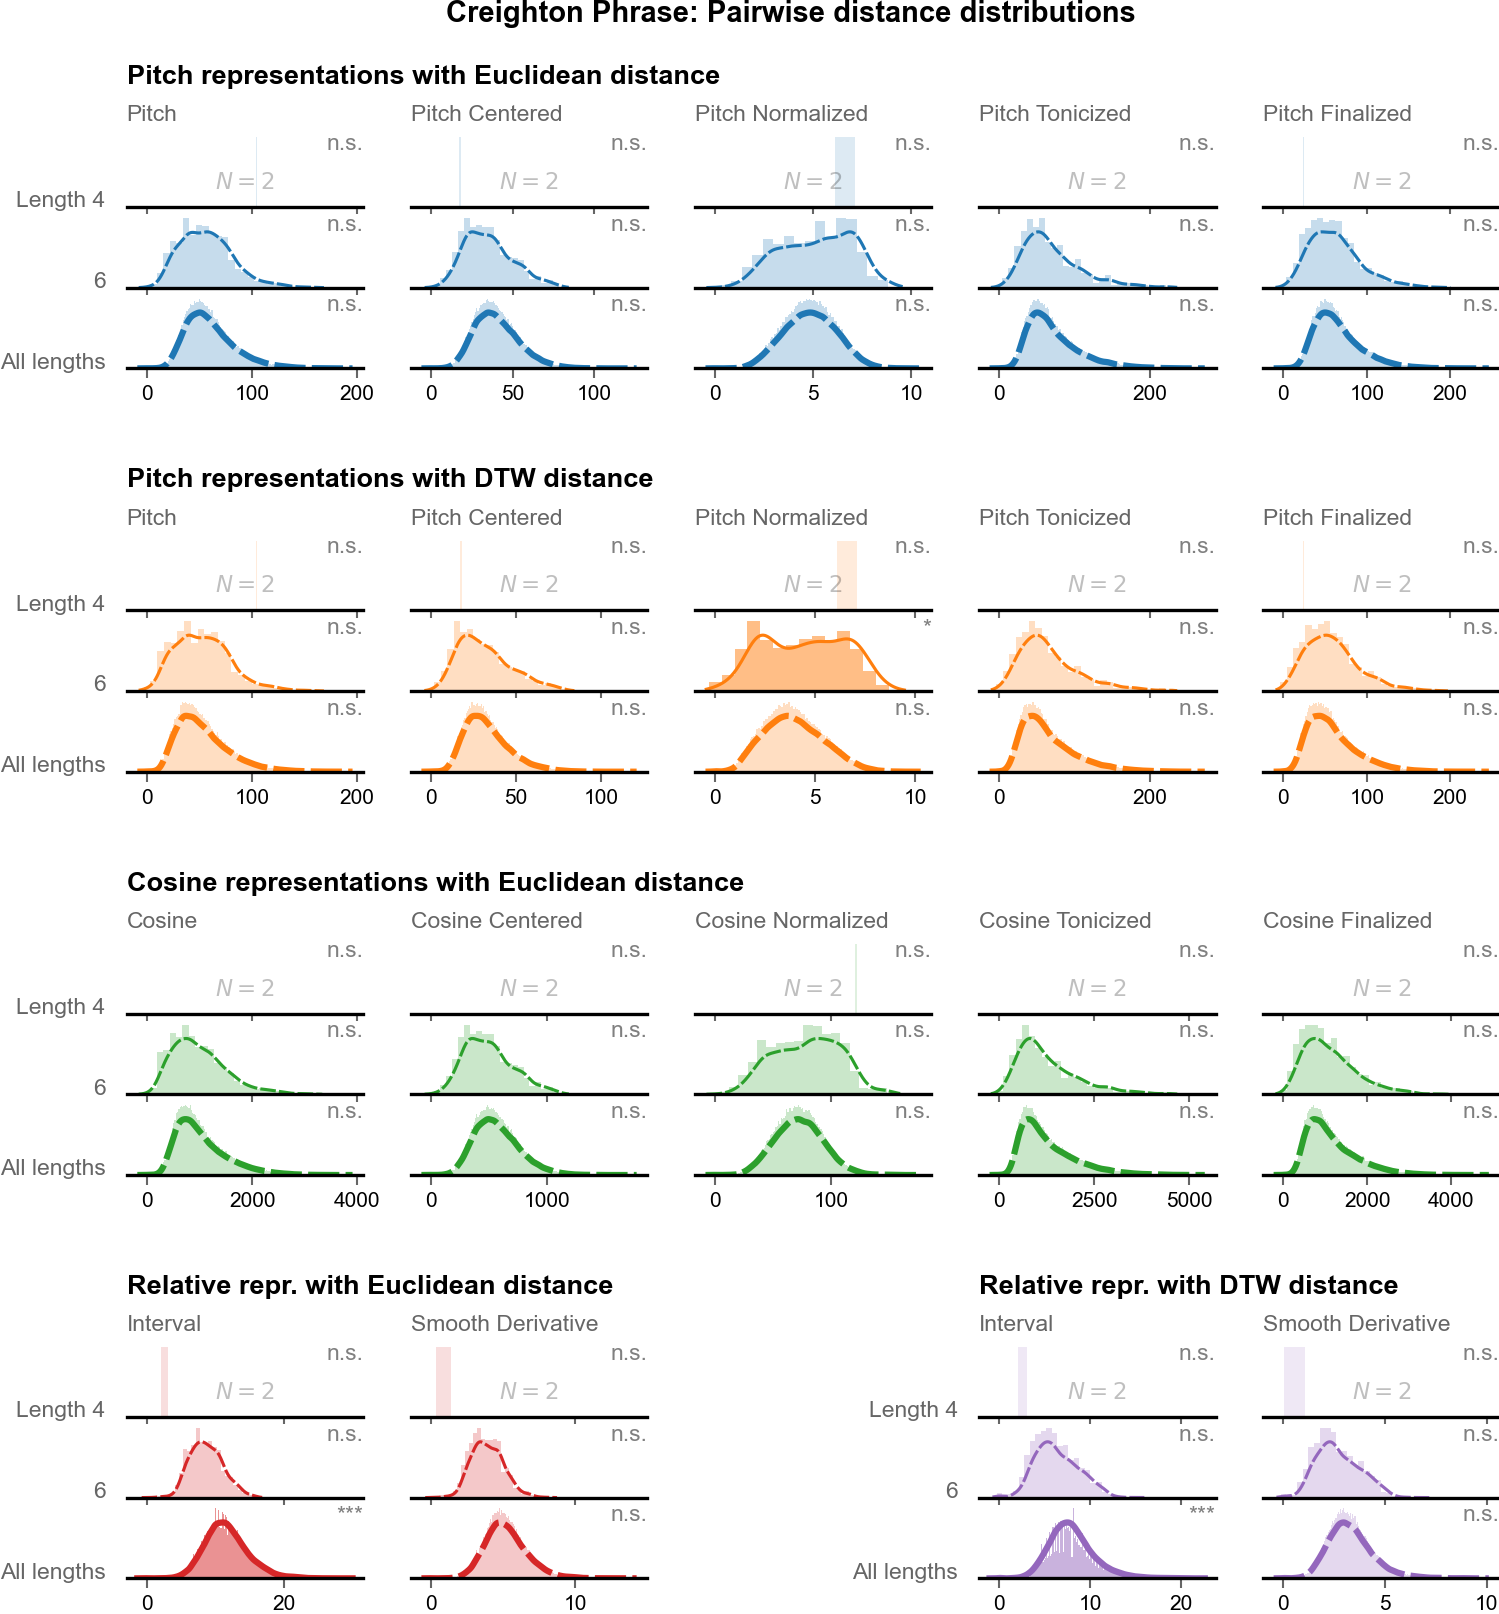

In [42]:
def plot_pairwise_distance_distributions(dataset, lengths, groups, num_group_rows=4, group_margin=2, cols=5):
    N = len(lengths) + 1
    rows = num_group_rows * (N+group_margin) - group_margin
    fig, axs = plt.subplots(rows, cols, 
                            figsize=cm2inch(cols*3, rows*.9), 
                            tight_layout=True,
                            gridspec_kw=dict(hspace=0.1))

    for group in groups:
        metric = group['metric']
        color = group['color']
        for repres, group_row, x in group['items']:
            y = group_row * (N + group_margin)
            ax0 = axs[y, x]
            group_axs = axs[y:y + N, x]

            # Plot length-wise distributions
            for length, ax in zip(lengths, group_axs[:-1]):
                ax.sharex(ax0)
                show_similarity_distribution(
                    dataset, repres, metric,
                    ax=ax, 
                    bar_kwargs=dict(color=color), 
                    plt_kwargs=dict(color=color, lw=.75),
                    length = length,
                    **group['subset'])

            # Plot distribution of all lengths combined
            group_axs[-1].sharex(ax0)
            show_similarity_distribution(
                dataset, repres, metric,
                ax=group_axs[-1], 
                bar_kwargs=dict(color=color), 
                plt_kwargs=dict(color=color, lw=1.5),
                **group['subset'])

            # Set column title: representation
            col_label(repres.replace('_', ' ').title(), ax=ax0)

            # Set up axes
            for i, ax in enumerate(group_axs): 
                ax.tick_params(color='0.4')
                if i == len(group_axs) - 1:
                    # ax.set_xlabel(f'{metric} distance', color='0.4')
                    pass
                else:
                    ax.tick_params(labelbottom=False)

        # Set title and annotate length in front of the y axis
        for offset, length in enumerate(lengths):
            ax = axs[group_row * (N + group_margin) + offset, group['label_column']]
            len_str = f'Length {length}' if offset == 0 else length 
            row_label(len_str, ax=ax)

        group_title(group['title'], ax=axs[group_row * (N + group_margin), group['label_column']])
        row_label('All lengths', ax=axs[group_row * (N + group_margin) + N - 1, group['label_column']])

    # Turn off axes for subplots between the groups
    for col in range(cols):
        for row in range(group_margin):
            axs[N + row, col].set_axis_off()
            axs[2*N + group_margin + row, col].set_axis_off()
            axs[3*N + 2*group_margin + row, col].set_axis_off()

    # Turn off axes between the groups in the final row  
    for length in range(N):
        axs[3*N + 3*group_margin + length, 2].set_axis_off()

    plt.suptitle(f'{dataset.dataset.replace("-", " ").title()}: Pairwise distance distributions',
                fontsize=7, fontweight='bold', y=.95, va='top')
    
dataset = Dataset('creighton-phrase')
plot_pairwise_distance_distributions(dataset, [4, 6], get_groups(subset_size=500))

In [43]:
datasets = [
    'boehme-phrase',
    'boehme-random',
    'erk-phrase',
    'erk-random',
    'creighton-phrase',
    'creighton-random',
    'han-phrase',
    'han-random',
    'natmin-phrase',
    'natmin-random',
    'shanxi-phrase',
    'shanxi-random',
    'liber-antiphons-phrase',
    'liber-antiphons-random',
    'liber-responsories-phrase',
    'liber-responsories-random',
    'liber-alleluias-phrase',
    'liber-alleluias-random',
    'cantus-antiphon-neumes',
    'cantus-antiphon-syllables',
    'cantus-antiphon-words',
    'cantus-antiphon-poisson-3',
    'cantus-antiphon-poisson-5',
    'cantus-antiphon-poisson-7',
    'cantus-responsory-neumes',
    'cantus-responsory-syllables',
    'cantus-responsory-words',
    'cantus-responsory-poisson-3',
    'cantus-responsory-poisson-5',
    'cantus-responsory-poisson-7'
]
for dataset_name in datasets:
    dataset = Dataset(dataset_name)
    max_subset_size = np.max([int(size) 
        for size, index in dataset.subsets['non-unique'].items() if index is not False])
    groups = get_groups(subset_size=min(1000, max_subset_size))
    lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
#     dataset = Dataset(dataset_name)
    plot_pairwise_distance_distributions(dataset, lengths, groups)
    plt.savefig(f'dist-figures/{dataset.dataset}.pdf')
    plt.close()

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/bas/repos/papers/contour-typo

In [15]:
# from experiment import DATASETS
# for dataset_name in DATASETS:
#     max_subset_size = np.max([int(size) 
#         for size, index in dataset.subsets['non-unique'].items() if index is not False])
#     groups = get_groups(subset_size=min(1000, max_subset_size))
#     lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
#     dataset = Dataset(dataset_name)
#     plot_pairwise_distance_distributions(dataset, lengths, groups)
#     plt.savefig(f'dist-figures/{dataset.dataset}.pdf')
#     plt.close()

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Old

In [ ]:
def show_dist_distribution(representation, metric, lengths, axs=None, set_title=True):
    if axs is None:
        fig, axs = plt.subplots(len(lengths), 1, 
                                figsize=cm2inch(5, len(lengths)),
                                tight_layout=True, sharex=True)
    for length, ax in zip(lengths, axs):
        sim = dataset.similarities(representation, metric, length=length, limit=500)
        sns.kdeplot(sim, ax=ax, shade=True)
        if set_title:
            ax.set_title(f'Length {length}', x=1, ha='right', y=.4, va='center')
        ax.set_ylabel(None)
        ax.set_yticks([])
        sns.despine(left=True, ax=ax)

    if set_title:
        plt.suptitle('Pairwise distance distribution', y=1.05, fontsize=7)
        axs[-1].set_xlabel('pairwise distance')

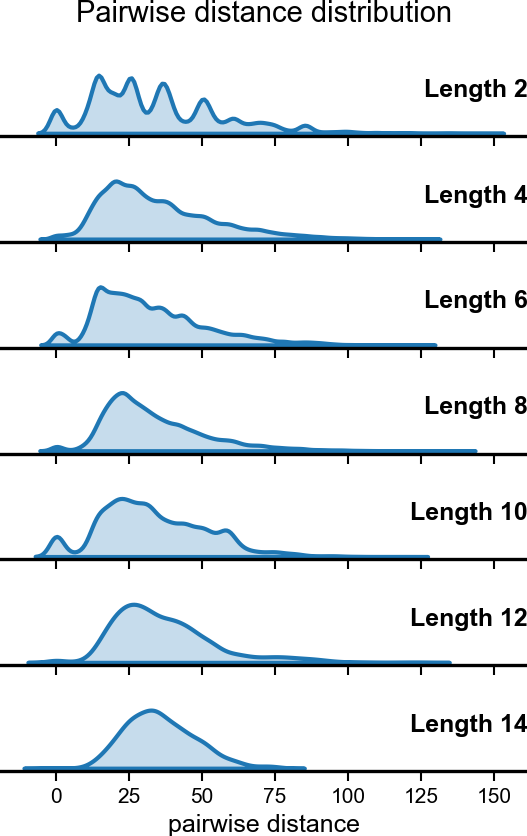

In [72]:
show_dist_distribution('pitch', 'eucl', range(2, 15, 2))

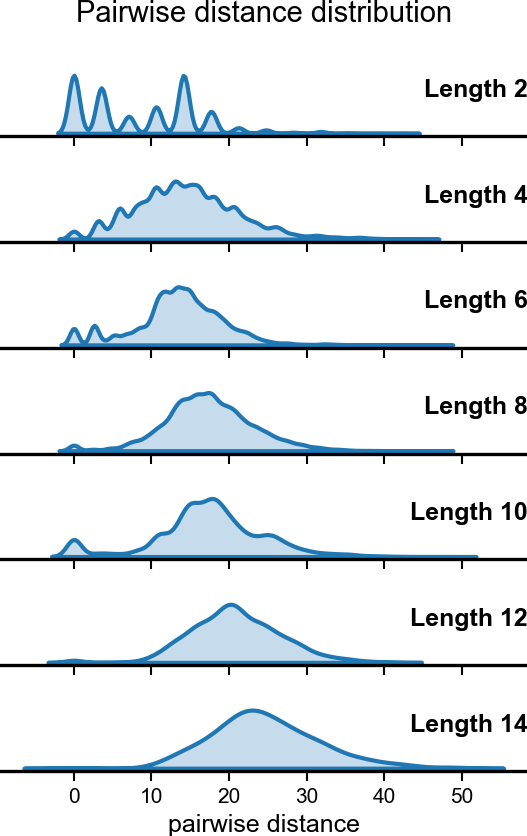

In [61]:
show_dist_distribution('pitch_centered', 'eucl', range(2, 15, 2))